# Training with CNN

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## Univariate timeseries

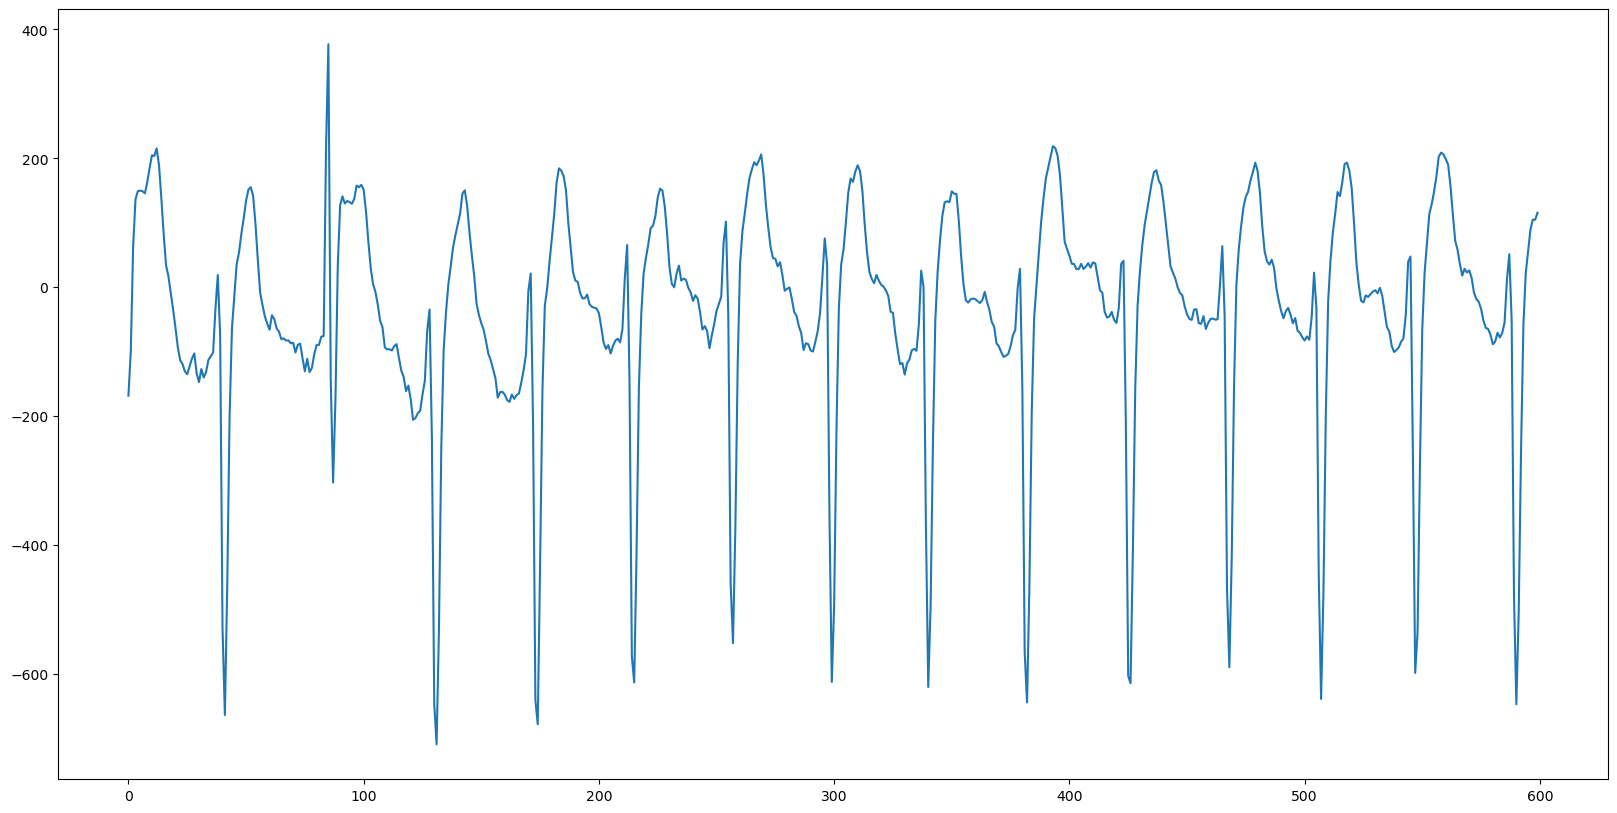

In [13]:
# Directory containing UCR time series files
ucr_directory = "../datasets/processed"

# Load the data
file_path = f"{ucr_directory}/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt"
time_series_data = pd.read_csv(file_path, header=None).squeeze("columns")

plt.figure(figsize=(20,10))
plt.plot(time_series_data[:600])

In [6]:
# Function to create input-output sequences for UNIVARIATE timeseries
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [7]:
sequence_length = 50 # this is the history length --> TODO: use the same used for RTs

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(time_series_data.values.reshape(-1, 1)).flatten()

X, y = create_sequences(normalized_data, sequence_length)

# Split into train and validation sets --> TODO: use the same split used for RTs
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Reshape for Conv1D input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

# Define the CNN model --> TODO: modify based on the hyperparameters optimization process
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

174/174 [==============================] - 11s 62ms/step - loss: 0.0189 - mae: 0.0976 - val_loss: 0.0061 - val_mae: 0.0503


## Multivariate timeseries

In [ ]:
# Directory containing UCR time series files
dataset_directory = "C:/Users/User/Downloads/Datasets/Datasets"

# Load the data
file_path = f"{dataset_directory}/traffic.csv"
data = pd.read_csv(file_path)

to_predict = 2 # Vehicles attribute is the feature with index 2 --> TODO: update based on dataset
n_steps_in = 24 # TODO: update the history length as used in RTs
n_steps_out = 2 # TODO: update the horizon as used in RTs

In [28]:
# split a multivariate sequence into samples
def split_multivariate_sequences(sequences, n_steps_in, n_steps_out,to_predict):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, to_predict]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [29]:
# Preprocess the data --> as for RTs?
# convert into seconds for scaler
data['DateTime'] = pd.to_datetime(data['DateTime'])
data['DateTime'] = (data['DateTime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# # Create sequences
# def create_sequences(data, sequence_length, target_column):
#     X, y = [], []
#     features data['DateTime', 'ID', target_column]).values
#     target = data[target_column].values
#     for i in range(len(data) - sequence_length):
#         X.append(features[i:i + sequence_length])
#         y.append(target[i + sequence_length])
#     return np.array(X), np.array(y)


#X, y = create_sequences(data, sequence_length, 'Vehicles')
X, y = split_multivariate_sequences(data,n_steps_in,n_steps_out,to_predict)

# Split into training and validation sets
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Define the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=1,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

1203/1203 [==============================] - 44s 36ms/step - loss: 0.0025 - mae: 0.0323 - val_loss: 0.0018 - val_mae: 0.0244
